# Navigation

---

This notebook shows how to use the Unity ML-Agents environment, how to implement a DQN agent that utilizes an experience replay buffer and fixed Q-targets. The goal is to train an agent to collect yellow bananas in a 2D gameplay while avoiding blue bananas in the given environment.

### 0. The Learning Algorithm

The basis of the implemented learning algorithm is called Sarsamax or Q-learning. It's an off-policy Temporal-Difference (TD) control method that updates the value function estimate after every ($C$) time step/s. It is guaranteed to converge as long as the stepsize parameter LR (the learning rate) is sufficiently small and epsilon is chosen to satisfy the Greedy in the Limit with Infinite Exploration (GLIE) conditions. Algorithm taken from *Reinforcment Learning, An introduction, second edition, by Richard S. Sutton and Andrew G. Barto*.

<img src="qlearning.png" width="500" align="center" title="Q-Learning Algorithm">

We implemented a version of Deep Q-Learning or DQN based on Mnih et al. (paper: [Human-level control through deep reinforcement learning](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)) that uses deep neural networks to approximate the optimal action-value function and enhances performance via two techniques: *Experience Replay*, and *Fixed Q-targets*. The Q-learning update at iteration $i$ uses the following loss
function:

<img src="q-update.png" width="350" align="center" title="Q-Learning Update at iteration i">

>in which $\gamma$ is the discount factor determining the agent’s horizon, $\theta_{i}$ are the parameters of the Q-network at iteration $i$ and $\theta_{i}^{-b}$ are the network parameters used to compute the target at iteration $i$. 

The chosen hyperparameters for our implementation are:
- SEED = 0
- GAMMA = 0.99
- EPS_STRT = 1.0
- EPS_END = 0.002
- EPS_DECAY = 0.99
- LR = 0.002
- TAU = 0.001
- BUFFER_SIZE = 100000 
- BATCH_SIZE = 64
- C = 4

The chosen model architecture for the (two) neural nets are as follows and we use ```Dropout(p=0.02)```:

```python
QNet(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)
```


### 1. Start the Environment

Importing some necessary packages. If the code cell below returns an error, please double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/) properly.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

**_Before running the code cell below_**: if you do not run this notebook on Mac OSX go back to the ```README.md``` file (see Dependencies 3.) to download a different version (Widows, Linux) of the ```Banana.app``` file and change the `file_name` path accordingly.

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

This is how a trained agent moves inside the environment (.gif taken from Udacity):

<img src="banana.gif" width="450" align="center" title="Banana environment">


Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will see how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, when it selects an action (uniformly) at random at each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment (check the ```README.md``` file for more details).  

Of course, the goal is to train an agent that is able to use its experience to gradually choose better actions when interacting with the environment!

**_Only uncomment and run the next two cells if you want to see a random agent._**

In [5]:
"""
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
"""

'\nenv_info = env.reset(train_mode=False)[brain_name] # reset the environment\nstate = env_info.vector_observations[0]            # get the current state\nscore = 0                                          # initialize the score\nwhile True:\n    action = np.random.randint(action_size)        # select an action\n    env_info = env.step(action)[brain_name]        # send the action to the environment\n    next_state = env_info.vector_observations[0]   # get the next state\n    reward = env_info.rewards[0]                   # get the reward\n    done = env_info.local_done[0]                  # see if episode has finished\n    score += reward                                # update the score\n    state = next_state                             # roll over the state to next time step\n    if done:                                       # exit loop if episode finished\n        break\n    \nprint("Score: {}".format(score))\n'

When finished, you can close the environment.

In [6]:
#env.close()

### 4. Training an agent to solve the environment

In the following you find implementations of ```run_dqn()```, ```Agent()```, ```QNet()```, and ```ReplayBuffer()```. The environment is considered solved when the agent is able to receive an average reward (over 100 episodes) of at least +13. 

In [7]:
def run_dqn(agent, num_episodes, eps_strt, eps_end, eps_decay):
    """ Run the dqn algorithm with an agent on given environment.
    
    Params
    ======
        agent: agent object (see Agent())
        nume_episodes: maximum number of episodes to train
        eps_strt: epsilon start value
        eps_end: epsilon min value
        eps_decay: epsilon decay value
        
    """
    scores = list()
    scores_window = deque(maxlen=100)
    eps = eps_strt
    
    for i_episode in range(1, num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] # get the current state
        score = 0 
        
        while True:
            action = agent.select_action(state, eps)
            env_info = env.step(action)[brain_name] 
            next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
            agent.step(state, action, next_state, reward, done)
            score += reward
            state = next_state
            if done:
                break
        
        scores.append(score)
        scores_window.append(score)
        eps = max(eps*eps_decay, eps_end)       # update epsilon
        
        print('\r{}/{} Episode. Avg score {:.3f}'.format(i_episode, num_episodes, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\r{}/{} Episode. Avg score {:.3f}'.format(i_episode, num_episodes, np.mean(scores_window)))
        
        if np.mean(scores_window) >= 13:
            # to solve the environment get an average score of +13 over 100 consecutive episodes.
            print('\rEnvironment solved after {} episodes'.format(i_episode))
            torch.save(agent.qnet_local.state_dict(), 'checkpoint.pth')
            break
    
    return scores

In [8]:
import torch
import torch.optim as optim


SEED = 0               # random seed
GAMMA = 0.99           # discounting factor
EPS_STRT = 1.0         # epsilon start value
EPS_END = 0.002        # epsilon end/minimum value
EPS_DECAY = 0.99       # epsilon decay factor
LR = 0.002             # learning rate
TAU = 0.001            # factor for target soft update
BUFFER_SIZE = 100000   # max replay buffer size
BATCH_SIZE = 64        # batch size
C = 4                  # update every C parameter

device = torch.device('cuda0' if torch.cuda.is_available() else 'cpu')


class Agent():
    """ Agent that implements the dqn algorithm with experience replay and fixed q-targets 
    to interact with and learn from the game environment."""
    
    def __init__(self, state_size, action_size, seed):
        """ Initialize the Agent object.
        Params
        ======
            state_size: dimension of each state
            action_size: dimension of each action
            seed: random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = np.random.seed(seed)
        self.step_t = 0 # init for update every C time steps
        
        # QNetwork
        self.qnet_local = QNet(state_size, action_size, SEED)
        self.qnet_target = QNet(state_size, action_size, SEED)
        self.optimizer = optim.Adam(self.qnet_local.parameters(), lr=LR)
        
        # Replay buffer
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, device, SEED)

    def select_action(self, state, eps):
        """ Return epsilon greedy action."""
        self.qnet_local.eval()
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # torch.Size([1, 37])
        do_explore = np.random.random() < eps
        
        if do_explore: # random action
            action = np.random.choice(np.arange(self.action_size))
        else:
            with torch.no_grad():
                action = np.argmax(self.qnet_local.forward(state).cpu().data.numpy()) # .cpu().data.numpy() vs.numpy() ?
        
        self.qnet_local.train()
        return action
    
    def step(self, state, action, next_state, reward, done):
        """ Add experience to memory and make learning step."""
        self.buffer.add(state, action, next_state, reward, done)
    
        self.step_t = (self.step_t + 1) % C
        if self.step_t == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
    
    def learn(self):
        """ Get batch of samples and update network parameters."""
        states, actions, next_states, rewards, dones = self.buffer.sample()
        self.optimizer.zero_grad()
        q_expected = self.qnet_local.forward(states).gather(1, actions) # torch.Size([64, 1])
        q_targets_next = self.qnet_target.forward(next_states).max(1)[0].unsqueeze(1) # torch.Size([64, 1])
        q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))
        loss = F.mse_loss(q_expected, q_targets)
        loss.backward()
        self.optimizer.step()
        self.soft_update_target()
    
    def soft_update_target(self):
        """ Copy local params to target params via Tau * local.params + (1-Tau) * target.params"""
        for target_params, local_params in zip(self.qnet_target.parameters(), self.qnet_local.parameters()):
            target_params.data.copy_(TAU * local_params.data + (1 - TAU) * target_params.data)
            

In [9]:
#import torch
import torch.nn as nn
import torch.nn.functional as F


class QNet(nn.Module):
    """ Policy neural network model that maps states to actions."""
    
    def __init__(self, state_size, action_size, seed):
        """ Initialize the neural net.
        
        Params
        ======
        state_size: dimension of each input state
        action_size: dimension of each output
        seed: random seed
        """
        super().__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, 128)
        self.dropout = nn.Dropout(p=0.02)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, action_size)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        
        return x

In [10]:
import random
from collections import deque, namedtuple


class ReplayBuffer():
    """ Experience replay buffer to store experience tuples."""
    
    def __init__(self, buffer_size, batch_size, device, seed):
        """ Initialize replay buffer object.
        Params
        ======
            buffer_size = max buffer size
            batch_size = size of each batch of training samples
            device = cpu/gpu
            seed = random seed
        """
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.device = device
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=self.buffer_size)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'next_state', 'reward', 'done'])
    
    def add(self, state, action, next_state, reward, done):
        """ Add new experience tuple to memory."""
        e = self.experience(state, action, next_state, reward, done)
        self.memory.append(e)
    
    def sample(self):
        """ Sample a batch of experience tuples from replay buffer"""
        experiences = random.sample(self.memory, self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if not None])).long().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if not None]).astype(np.uint8)).float().to(self.device)
        
        return (states, actions, next_states, rewards, dones)
    
    def __len__(self):
        """ Return length of current buffer memory."""
        return len(self.memory)

In [11]:
agent = Agent(state_size, action_size, SEED)
scores = run_dqn(agent, num_episodes=2000, eps_strt=EPS_STRT, eps_end=EPS_END, eps_decay=EPS_DECAY)
env.close()

scores = np.array(scores)
x = np.where(scores >= 13)
print('The first time a score >= 13 was reached at episode {}.'.format(x[0][0]))
print('Max score reached: ', np.amax(scores))

100/2000 Episode. Avg score 0.210
200/2000 Episode. Avg score 3.260
300/2000 Episode. Avg score 8.510
400/2000 Episode. Avg score 10.080
500/2000 Episode. Avg score 10.480
600/2000 Episode. Avg score 12.970
Environment solved after 605 episodes
The first time a score >= 13 was reached at episode 198.
Max score reached:  23.0


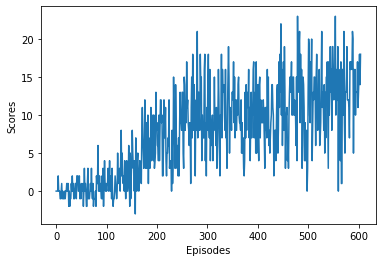

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Scores')
plt.xlabel('Episodes')
plt.show()

### 5. Ideas for Future Work

To reach even better results one can implement:
- Double DQN (DDQN) (paper: [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)),
- Prioritized experience replay (paper: [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)), or
- Dueling DQN (paper: [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)), or
- going even further and combining improvements in RL (paper: [Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298))


This notebook is a project submission for the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). If you are interested to learn more about Deep Reinforcement Learning - I can highly recommend it.